In [4]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [5]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

170500096/170498071 [==============================] - 2s 0us/step


In [6]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [7]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [8]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Create simple convolutional neural network classifier

In [9]:
# Create an instance of the model and show model summary
model = get_new_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12576     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 14,514
Trainable params: 14,514
Non-trainable params: 0
__________________________________________________

In [10]:
# Test accuracy of the untrained model, around 10% (random)
get_test_accuracy(model, x_test, y_test)


accuracy: 0.115


#### Train model with checkpoints

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
# Create Tensorflow checkpoint object
filepath='checkpoints/checkpoint'
checkpoint = ModelCheckpoint(filepath=filepath, frequency='epoch', save_weights_only=True, verbose=1)


In [13]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch
model.fit(x_train, y_train, epochs=10, validation_split=0.1, callbacks=[checkpoint])


Train on 9000 samples, validate on 1000 samples
Epoch 1/10
8992/9000 [============================>.] - ETA: 0s - loss: 2.0080 - accuracy: 0.2697
Epoch 00001: saving model to checkpoints/checkpoint
9000/9000 [==============================] - 52s 6ms/sample - loss: 2.0076 - accuracy: 0.2699 - val_loss: 1.7609 - val_accuracy: 0.3580
Epoch 2/10
8992/9000 [============================>.] - ETA: 0s - loss: 1.6178 - accuracy: 0.4289 ETA: 0s - loss: 1.6193 - accuracy: 
Epoch 00002: saving model to checkpoints/checkpoint
9000/9000 [==============================] - 48s 5ms/sample - loss: 1.6175 - accuracy: 0.4291 - val_loss: 1.5885 - val_accuracy: 0.4020
Epoch 3/10
8992/9000 [============================>.] - ETA: 0s - loss: 1.4810 - accuracy: 0.4728
Epoch 00003: saving model to checkpoints/checkpoint
9000/9000 [==============================] - 48s 5ms/sample - loss: 1.4810 - accuracy: 0.4727 - val_loss: 1.4810 - val_accuracy: 0.4550
Epoch 4/10
8992/9000 [============================>.] - ET

In [16]:
# Have a look at what the checkpoint creates

!ls -lh checkpoints

total 184K
-rw-r--r-- 1 jovyan users   77 Sep  4 18:19 checkpoint
-rw-r--r-- 1 jovyan users 174K Sep  4 18:19 checkpoint.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Sep  4 18:19 checkpoint.index


In [17]:
# Evaluate the performance of the trained model

get_test_accuracy(model, x_test, y_test)

accuracy: 0.539


#### Create new model, load weights

In [18]:
# Create a new instance of the (initialised) model, accuracy around 10% again
model = get_new_model()

model.evaluate(x_test, y_test)

1000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[2.3310211486816406, 0.115]

In [20]:
# Load weights -- accuracy is the same as the trained model

model.load_weights(filepath)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.539


#### Clear directory

In [21]:
! rm -r model_checkpoints

rm: cannot remove 'model_checkpoints': No such file or directory


***
<a id="coding_tutorial_2"></a>
## Model saving criteria

#### Create more customised checkpoint

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [31]:
# Create Tensorflow checkpoint object with epoch and batch details

checkpoint_500_path = "checkpoints_500/checkpoint-{epoch:02d}-{batch:04d}" 
checkpoint_500 = ModelCheckpoint(filepath=checkpoint_500_path, save_freq=500, save_weights_only=True, verbose=False)

In [25]:
# Create and fit model with checkpoint
model = get_new_model()
model.fit(x_train, y_train, epochs=3, batch_size=10, validation_split=0.1, callbacks=[checkpoint_500])


Train on 9000 samples, validate on 1000 samples
Epoch 1/3
9000/9000 [==============================] - 55s 6ms/sample - loss: 1.9113 - accuracy: 0.2990 - val_loss: 1.7409 - val_accuracy: 0.3760
Epoch 2/3
9000/9000 [==============================] - 54s 6ms/sample - loss: 1.5163 - accuracy: 0.4509 - val_loss: 1.5312 - val_accuracy: 0.4460
Epoch 3/3
9000/9000 [==============================] - 54s 6ms/sample - loss: 1.3941 - accuracy: 0.5029 - val_loss: 1.4719 - val_accuracy: 0.4730


In [32]:
# Have a look at what the checkpoint creates
!ls -lh checkpoints_500


total 184K
-rw-r--r-- 1 jovyan users   77 Sep  4 18:29 checkpoint
-rw-r--r-- 1 jovyan users 174K Sep  4 18:29 checkpoint.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Sep  4 18:29 checkpoint.index


#### Work with model saving criteria

In [26]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [27]:
# Create a new instance of untrained model

model = get_new_model()

In [33]:
# Create Tensorflow checkpoint object which monitors the validation accuracy

checkpoint_best_path = "checkpoints_best/checkpoint"
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                 save_freq='epoch',
                                 save_weights_only=True,
                                 monitor='val_accuracy',
                                 save_best_only=True,
                                 verbose=1)

In [34]:
# Fit the model and save only the weights with the highest validation accuracy

model = get_new_model()
history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    epochs=50,
                    batch_size=10,
                    verbose=1,
                   callbacks=[checkpoint_best])

Train on 90 samples, validate on 10 samples
Epoch 1/50
70/90 [======================>.......] - ETA: 0s - loss: 2.3272 - accuracy: 0.0857
Epoch 00001: val_accuracy improved from -inf to 0.20000, saving model to checkpoints_best/checkpoint
90/90 [==============================] - 2s 17ms/sample - loss: 2.3273 - accuracy: 0.1000 - val_loss: 2.3209 - val_accuracy: 0.2000
Epoch 2/50
70/90 [======================>.......] - ETA: 0s - loss: 2.2682 - accuracy: 0.1714
Epoch 00002: val_accuracy improved from 0.20000 to 0.40000, saving model to checkpoints_best/checkpoint
90/90 [==============================] - 1s 8ms/sample - loss: 2.2606 - accuracy: 0.1889 - val_loss: 2.2786 - val_accuracy: 0.4000
Epoch 3/50
70/90 [======================>.......] - ETA: 0s - loss: 2.2272 - accuracy: 0.1429
Epoch 00003: val_accuracy did not improve from 0.40000
90/90 [==============================] - 0s 5ms/sample - loss: 2.2305 - accuracy: 0.1333 - val_loss: 2.2481 - val_accuracy: 0.4000
Epoch 4/50
80/90 [==

Epoch 30/50
80/90 [=========================>....] - ETA: 0s - loss: 0.2673 - accuracy: 0.9750
Epoch 00030: val_accuracy improved from 0.40000 to 0.50000, saving model to checkpoints_best/checkpoint
90/90 [==============================] - 1s 8ms/sample - loss: 0.2722 - accuracy: 0.9667 - val_loss: 2.4813 - val_accuracy: 0.5000
Epoch 31/50
80/90 [=========================>....] - ETA: 0s - loss: 0.1989 - accuracy: 0.9750
Epoch 00031: val_accuracy did not improve from 0.50000
90/90 [==============================] - 1s 6ms/sample - loss: 0.2027 - accuracy: 0.9778 - val_loss: 2.6973 - val_accuracy: 0.4000
Epoch 32/50
80/90 [=========================>....] - ETA: 0s - loss: 0.1671 - accuracy: 0.9875
Epoch 00032: val_accuracy did not improve from 0.50000
90/90 [==============================] - 1s 6ms/sample - loss: 0.1738 - accuracy: 0.9889 - val_loss: 2.4335 - val_accuracy: 0.5000
Epoch 33/50
80/90 [=========================>....] - ETA: 0s - loss: 0.1485 - accuracy: 1.0000
Epoch 00033: 

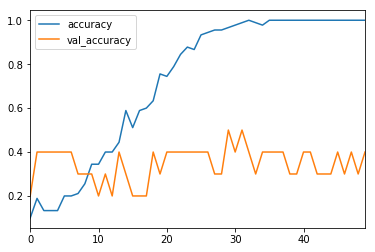

In [35]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [39]:
# Inspect the checkpoint directory

! ls -lh checkpoints_best

total 184K
-rw-r--r-- 1 jovyan users   77 Sep  4 18:32 checkpoint
-rw-r--r-- 1 jovyan users 174K Sep  4 18:32 checkpoint.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Sep  4 18:32 checkpoint.index


In [43]:
# Create a new model with the saved weights

new_model = get_new_model()
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.190


#### Clear directory

In [45]:
! rm -r checkpoints_500 checkpoints_best

rm: cannot remove 'model_checkpoints_5000': No such file or directory


***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [46]:
# Create Tensorflow checkpoint object
checkpoint_entire_model_path = "checkpoints_entire_model"
checkpoint_entire_model = ModelCheckpoint(
    filepath=checkpoint_entire_model_path,
    verbose=1,
    save_weights_only=False,
    frequency='epoch'
)


In [54]:
# Create and fit model with checkpoint
model = get_new_model()
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]
model.fit(x_train, y_train,
         epochs=3,
          validation_split=0.1,
          callbacks=[checkpoint_entire_model]
         )


Train on 9000 samples, validate on 1000 samples
Epoch 1/3
8992/9000 [============================>.] - ETA: 0s - loss: 2.0454 - accuracy: 0.2395
Epoch 00001: saving model to checkpoints_entire_model
INFO:tensorflow:Assets written to: checkpoints_entire_model/assets
9000/9000 [==============================] - 49s 5ms/sample - loss: 2.0451 - accuracy: 0.2396 - val_loss: 1.7658 - val_accuracy: 0.3410
Epoch 2/3
8992/9000 [============================>.] - ETA: 0s - loss: 1.6935 - accuracy: 0.3804
Epoch 00002: saving model to checkpoints_entire_model
INFO:tensorflow:Assets written to: checkpoints_entire_model/assets
9000/9000 [==============================] - 47s 5ms/sample - loss: 1.6935 - accuracy: 0.3807 - val_loss: 1.6824 - val_accuracy: 0.3780
Epoch 3/3
8992/9000 [============================>.] - ETA: 0s - loss: 1.5847 - accuracy: 0.4249
Epoch 00003: saving model to checkpoints_entire_model
INFO:tensorflow:Assets written to: checkpoints_entire_model/assets
9000/9000 [===============

#### Inspect what the checkpoint has created

In [52]:
# Have a look at what the checkpoint creates

! ls -lh checkpoints_entire_model

total 128K
drwxr-xr-x 2 jovyan users 6.0K Sep  4 18:44 assets
-rw-r--r-- 1 jovyan users 119K Sep  4 18:44 saved_model.pb
drwxr-xr-x 2 jovyan users 6.0K Sep  4 18:44 variables


In [53]:
# Enter variables directory

! ls -lh checkpoints_entire_model/variables

total 184K
-rw-r--r-- 1 jovyan users 177K Sep  4 18:44 variables.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.1K Sep  4 18:44 variables.index


In [55]:
# Get the model's test accuracy

get_test_accuracy(model, x_test, y_test)

accuracy: 0.458


#### Create new model from scratch

In [56]:
# Delete model

del model

In [57]:
from tensorflow.keras.models import load_model

In [59]:
# Reload model from scratch

model = load_model(checkpoint_entire_model_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.458


#### Use the .h5 format to save model

In [60]:
# Save the model in .h5 format

model.save('my_keras_model.h5')

In [61]:
# Inspect .h5 file

! ls -lh 

total 196K
drwxr-xr-x 2 jovyan users   6.0K Sep  4 18:29  checkpoints
drwxr-xr-x 4 jovyan users   6.0K Sep  4 18:44  checkpoints_entire_model
-rwxrwxrwx 1 nobody nogroup 100K Sep  4 18:50 'Coding Tutorial.ipynb'
drwxrwxrwx 2 nobody nogroup 6.0K Sep  4 12:00  data
drwxrwxrwx 3 nobody nogroup 6.0K Sep  4 12:00  models
-rw-r--r-- 1 jovyan users    77K Sep  4 18:52  my_keras_model.h5


In [66]:
# Delete model

del model

In [67]:
# Reload model from scratch

model = load_model("my_keras_model.h5")

#### Clear directory

In [ ]:
! rm -r checkpoints_entire_model
! rm my_model.h5

***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Keras HDF5 format. If you want to import it on your personal machine, use the following code:

```python
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')
```

In this coding tutorial, you will instead load the model directly from disk.

In [ ]:
from tensorflow.keras.models import load_model

In [73]:
# Build Keras ResNet50 model
from tensorflow.keras.applications.resnet50 import ResNet50

model = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 0s 0us/step


In [74]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

#### Import and preprocess 3 sample images

In [75]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('data/lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('data/viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('data/water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [76]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

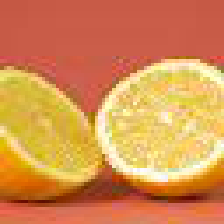

In [77]:
# Display image

lemon_img

In [78]:
# Display top 5 predictions

get_top_5_predictions(lemon_img)

40960/35363 [==================================] - 0s 0us/step


,prediction,probability
1,consomme,0.227801
2,lemon,0.221758
3,eggnog,0.151335
4,ladle,0.0400883
5,spotlight,0.0291972


##### Image 2: viaduct

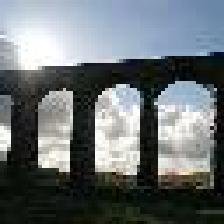

In [80]:
# Display image

viaduct_img

In [81]:
# Display top 5 predictions

get_top_5_predictions(viaduct_img)

,prediction,probability
1,vault,0.367951
2,prison,0.111742
3,viaduct,0.110738
4,window_screen,0.0882307
5,fire_screen,0.0206752


##### Image 3: water tower

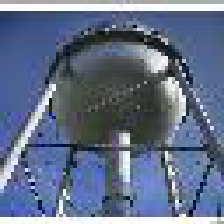

In [82]:
# Display image

water_tower_img

In [83]:
# Display top 5 predictions

get_top_5_predictions(water_tower_img)

,prediction,probability
1,solar_dish,0.384681
2,ladle,0.196179
3,planetarium,0.116682
4,strainer,0.04999
5,jigsaw_puzzle,0.0219473


***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Tensorflow SavedModel format. If you want to import it on your personal machine, use the following code:

```python
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
```

In this coding tutorial, you will instead load the model directly from disk.

In [85]:
import tensorflow_hub as hub
from tensorflow.keras.models import load_model

In [86]:
# Build Google's Mobilenet v1 model
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])


#### Use MobileNet model to classify images

In [87]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img("data/lemon.jpg", target_size=(160, 160))
viaduct_img = load_img("data/viaduct.jpg", target_size=(160, 160))
water_tower_img = load_img("data/water_tower.jpg", target_size=(160, 160))

In [88]:
# Read in categories text file

with open('data/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [89]:
# Useful function: presents top 5 predictions

import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds

##### Image 1: lemon

In [90]:
get_top_5_predictions(lemon_img)

,prediction
1,shower cap
2,tray
3,candle
4,brassiere
5,African chameleon


##### Image 2: viaduct

##### Image 3: water tower